# Image Nosebook: Tracing Visual Smell Trends

![Odereuropa Image Data Teaser](https://lh3.googleusercontent.com/drive-viewer/AK7aPaACCJOuTPv6r9fjnWuRoD21WiSitS3aEbV2pLtXzVlUeOiFRgYXy7kPg8kv3yGWPOdg8QVHoMCzH8NqhFN3ZJJerjtB=s1600)

Welcome to this Jupyter Notebook designed for the exploration of the Odeuropa Project Image Data. It consists of three main parts:

1. Code and data preparation. This part can mostly be ignored. Just run it once by clicking on "run cell" button (right-facing triangle button to the left of the cells).
2. Query Image Data. This section enables you to explore our image data by querying for smell-related objects annotated in the images, or by the image meta data.
3. Quantitative Analysis. In this section, you will see an examplarily walkthrough of how the annotations and meta data can be used to gain statistical insights.

Each code cell is collapsed by default. Feel free to expand the cells, explore and play around with the code. Don't be afraid to break things, you are working on a local copy of the notebook and the original version can always be restored.


# Code and Data Preparation
Run the following cells to prepare the code and data for exploration. As long as the section is collapsed, you don't have to do anything but click on the triangle within the circle and wait. Note that this will take 15-20 minutes as the images have to loaded into the colab instance. In the meantime, we suggest you grab a cup of tea or coffee and enjoy its beautiful smell or coffee or explore the textual reference [nosebook](https://bit.ly/odeuropa-text).



## Code Preparation

### import libraries

In [ ]:
import pycocotools.coco as coco
import os
import matplotlib.pyplot as plt
import json
import cv2
import pandas as pd
import ipywidgets as widgets
from ipywidgets.widgets import interact, interact_manual
import time
import io
from IPython.display import display, clear_output, Image, HTML


widgets.__version__

'7.7.1'

### Define helper functions

In [ ]:
from google.colab import drive

def mount_drive():
  drive.mount('/content/drive')

def filter_cats_conf(coco_json, cat_ids, min_confidence):
  anns =  [ann for ann in coco_json['annotations'] if ann['category_id'] in cat_ids and ann['score'] >= min_confidence]
  return anns

def get_anns_for_conf(confidence):
  return [ann for ann in annotations_json['annotations'] if ann['score'] >= confidence]

def filter_years(anns, year_min, year_max):
  return [ann for ann in anns if ann['year'] is not None if ann['year'] >= year_min if ann['year'] <= year_max]

def get_subcats(supercat):
  return [cat['name'] for cat in annotations_json['categories'] if cat['supercategory'] == supercat]

def get_supercat(subcat):
  subcat_id = cat_name_to_id[subcat]
  return [cat['supercategory'] for cat in annotations_json['categories'] if cat['id'] == subcat_id][0]

def get_cat_family(supercat):
  return get_subcats(supercat)+ [supercat]

def filter_category_intersection(coco_json, cat_ids, min_confidence):
  cat_imids = []
  candidate_anns = filter_cats_conf(coco_json, cat_ids, min_confidence)
  for cat_id in cat_ids:
    imids = set([ann['image_id'] for ann in candidate_anns if ann['category_id'] == cat_id and ann['score'] >= min_confidence])
    cat_imids.append(imids)
  matching_imids = set.intersection(*cat_imids)

  imgs = [img for img in coco_json['images'] if img['id'] in matching_imids]
  anns = [ann for ann in candidate_anns if ann['image_id'] in matching_imids]
  return imgs, anns

def get_meta(df, img):
    fn = os.path.basename(img['file_name'])
    meta = df[df['File Name'] == fn]
    return meta


def draw_boxes(coco_img, anns):
  cv2img = cv2.imread(f'{IMG_DIR}/{coco_img["file_name"]}')
  if cv2img is None:
    return np.zeros((256,256))
  cv2img = cv2.cvtColor(cv2img,cv2.COLOR_BGR2RGB)
  cur_anns = [ann for ann in anns if ann['image_id'] == coco_img['id']]
  box_color = (255,255,0)
  for ann in cur_anns:
    score_str = f'{ann["score"]:.2f}'
    [x,y,w,h] = ann['bbox']
    cv2img = cv2.rectangle(cv2img, (int(x), int(y)), (int(x+w), int(y+h)), box_color, 2)
    cv2img = cv2.putText(cv2img, score_str, (int(x) + 5, int(y) + 25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, box_color, 1)
  return cv2img

def display_hack():
  buf = io.BytesIO()
  plt.savefig(buf, format='png', bbox_inches='tight',pad_inches=0)
  buf.seek(0)
  plt.close()
  clear_output(wait=True)
  display(Image(data=buf.read(), format='png'))


def browse_images(anns, imgs, extra_meta=[]):
  n = len(imgs)
  def view_image(i):
    coco_img = imgs[i]
    meta = get_meta(df, coco_img)
    img = draw_boxes(coco_img, anns)
    h,w,_ = img.shape
    figsize = [min((w/100) + 10, 20), min((h/100),8)]
    fig, ax_image = plt.subplots(1,1,figsize=figsize)
    ax_image.axis('off')
    ax_image.imshow(img)
    display_hack()
    print(f'Image Source: {meta["Details URL"].values[0]}')
    for meta_key in extra_meta:
      meta_val = meta[meta_key].values[0]
      print(f'{meta_key}: {meta_val}')
  interact(view_image, i=(0,n-1), continuous_update=False)


def extract_nested_vals(df, key):
  vals = set()
  for val_str in df[df[key].notnull()][key].values:
    vals.update([val.strip() for val in val_str.split(',')])
  return list(vals)
def generate_nested_val_map(df, col_name):
  key_to_fns = {}
  for _,row in df[df[col_name].notnull()].iterrows():
    for val in row[col_name].split(','):
      val = val.strip().lower()
      if val in key_to_fns.keys():
        key_to_fns[val].append(row['File Name'])
      else:
        key_to_fns[val] = [row['File Name']]
  return key_to_fns
def generate_val_map(df, col_name):
  col_name_to_fns = {}
  for _,row in df[df[col_name].notnull()].iterrows():
    val = row[col_name].strip().lower()
    if val in col_name_to_fns.keys():
      col_name_to_fns[val].append(row['File Name'])
    else:
      col_name_to_fns[val] = [row['File Name']]
  return col_name_to_fns
def distinct_vals(df, key):
  matches = df[df[key].notnull()]
  return list(matches[key].unique())

### Define Widgets for Object-Based Search

In [ ]:
def create_obj_query_ui():
  def search_by_obj(b):
    def is_selection_search():
      return tab.selected_index == 1

    with out:
      clear_output(wait=True)
      if is_selection_search():
        cats = cat_selector.value
      else: # text search
        if cat_picker.value not in catnames:
          print(f'{cat_picker.value} not in searchable categories. Please try something else.')
          return
        cats = [cat_picker.value]
      if preds_picker.value is False:
        conf = 1.0
      else:
        conf = conf_picker.value
      print(f'Searching for {cats} with minimum confidence {conf}')
      cat_ids = [cat_name_to_id[cat] for cat in cats]
      matching_imgs, matching_annotations = filter_category_intersection(annotations_json, cat_ids, conf)
      if len(matching_imgs) ==0:
        print(f'No images found where {cats} are all present. Please try a different combination.')
        return
      print(f'{len(matching_annotations)} instances on {len(matching_imgs)} images found.')

      browse_images(matching_annotations, matching_imgs)

  out = widgets.Output()
  cat_picker = widgets.Combobox(
      options=catnames,
      description='Type Name'
  )
  cat_selector = widgets.SelectMultiple(
      options=catnames,
      description='Select Object'
  )
  conf_picker = widgets.FloatSlider(
      value=0.5,
      min=0.0,
      max=1.0,
      step=0.05,
      description='Confidence'
  )
  preds_picker = widgets.Checkbox(
      value=True,
      description='Include Predictions'
  )
  button = widgets.Button(
      description = 'Search',
      icon='search',
      align='center'
  )
  inner_box = widgets.VBox([conf_picker, preds_picker, button],align='center')
  pickerbox = widgets.Box([cat_picker, inner_box])
  selectorbox = widgets.Box([cat_selector, inner_box])
  tab = widgets.Tab([pickerbox,selectorbox])
  tab.set_title(0,'Type Name')
  tab.set_title(1,'Pick Category')
  inoutbox = widgets.VBox([tab, out])
  button.on_click(search_by_obj)

  return inoutbox


### Define Widgets for Metadata Search

In [ ]:
def generate_metadata_ui():
  kw_select = widgets.Combobox(
    placeholder='Type Keyword',
    options=keywords,
    description='Keyword'
  )
  artist_select = widgets.Combobox(
    placeholder='Type Artist',
    options=artists,
    description='Keyword'
  )
  title_select = widgets.Text(
    placeholder='Type Title Query',
    description='Title'
  )
  desc_select = widgets.Text(
    placeholder='Type Description Query',
    description='Description'
  )
  ic_select = widgets.Combobox(
      placeholder='Type Iconclass Code',
      options=iconclass_codes,
      description='Iconclass Code'
  )
  search_button = widgets.Button(
      description = 'Search',
      icon='search',
      align='center'
  )
  kw_search_box = widgets.HBox([kw_select, search_button])
  desc_search_box = widgets.HBox([desc_select, search_button])
  artist_search_box = widgets.HBox([artist_select, search_button])
  title_search_box = widgets.HBox([title_select, search_button])
  iconclass_search_box = widgets.HBox([ic_select, search_button])

  out = widgets.Output()
  tab = widgets.Tab([kw_search_box, desc_search_box, artist_search_box, title_search_box, iconclass_search_box])
  tab.set_title(0,'By Keyword')
  tab.set_title(1,'By Description')
  tab.set_title(2, 'By Artist')
  tab.set_title(3, 'By Title')
  tab.set_title(4, 'By Iconclass Code')
  inoutbox = widgets.VBox([tab, out])

  def coco_from_fns(fns):
    return [img for img in annotations_json['images'] if img['file_name'] in fns]

  def filter_by_kw(kw):
    kw = kw.lower()
    matching_fns = keyword_to_filenames[kw]
    return coco_from_fns(matching_fns)

  def filter_by_substring(key, substring):
    candidates = df[df[key].notnull()]
    matching_fns = []
    for _, row in candidates.iterrows():
      if substring in row[key]:
        matching_fns.append(row['File Name'])
    return coco_from_fns(matching_fns)

  def filter_by_desc(desc_str):
    desc_df = df[df['Description'].notnull()]
    #print(f'Querying {len(desc_df)} image descriptions..')
    matching_fns = []
    for _,row in desc_df.iterrows():
      if desc_str in row['Description']:
        matching_fns.append(row['File Name'])
    return coco_from_fns(matching_fns)

  def filter_by_artist(art_str):
    artist = art_str.strip().lower()
    matching_fns = artist_to_filenames[artist]
    return coco_from_fns(matching_fns)

  def filter_by_iconclass(ic_str):
    ic = ic_str.strip().lower()
    matching_fns = iconclass_to_fns[ic]
    return coco_from_fns(matching_fns)

  def search_by_meta(b):
    try:
      if tab.selected_index == 0:
        matching_imgs = filter_by_kw(kw_select.value)
        extra_meta = ['Keywords']
      if tab.selected_index == 1:
        matching_imgs = filter_by_desc(desc_select.value)
        extra_meta = ['Description']
      if tab.selected_index == 2:
        matching_imgs = filter_by_artist(artist_select.value)
        extra_meta = ['Artist']
      if tab.selected_index == 3:
        matching_imgs = filter_by_substring('Title', title_select.value)
        extra_meta = ['Title']
      if tab.selected_index == 4:
        matching_imgs = filter_by_iconclass(ic_select.value)
        extra_meta = ['Iconclass code']
    except KeyError:
      print('Metadata not found. Try again.')
      return
    if len(matching_imgs) == 0:
      print('No results for query.')
      return
    with out:
      clear_output(wait=True)
      print(f'Loading {len(matching_imgs)} results..')
      browse_images([], matching_imgs, extra_meta=extra_meta)
  search_button.on_click(search_by_meta)
  return inoutbox

## Prepare the data

#### Collect Images, Annotations, and Metadata


In [ ]:
print('Collecting data from zenodo...')
!wget 'https://zenodo.org/records/10209441/files/demonstrator_images.zip?download=1' -O data.zip
  # !wget 'https://zenodo.org/records/10124448/files/demonstrator_images.zip?download=1' -O data.zip
print('Unzipping data...')
!unzip -o data.zip | awk 'BEGIN {ORS=" "} {if(NR%10==0)print "."}'
IMG_DIR = 'compressed'
preds_pth = 'preds_with_years.json'
meta_pth = 'meta.csv'

--2023-11-30 14:24:54--  https://zenodo.org/records/10209441/files/demonstrator_images.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.184.103.159, 188.184.98.238, 188.185.79.172, ...
Connecting to zenodo.org (zenodo.org)|188.184.103.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9839660376 (9.2G) [application/octet-stream]
Saving to: ‘data.zip’

data.zip            100%[===================>]   9.16G  50.0MB/s    in 4m 2s   

2023-11-30 14:28:57 (38.7 MB/s) - ‘data.zip’ saved [9839660376/9839660376]

Unzipping data...
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

#### Prepare Data for Processing

In [ ]:
with open(preds_pth) as f:
  annotations_json = json.load(f)
# annotations_df = pd.DataFrame(annotations_json['annotations'])
fn_to_imgid = {os.path.basename(img['file_name']):img['id'] for img in annotations_json['images']}
imgid_to_fn = {v:k for k,v in fn_to_imgid.items()}
cat_id_to_name = {cat['id']: cat['name'] for cat in annotations_json['categories']}
cat_name_to_id = {v:k for k,v in cat_id_to_name.items()}
catnames = list(cat_name_to_id.keys())
supercats = list(set([cat['supercategory'] for cat in annotations_json['categories']]))

df = pd.read_csv(meta_pth)
keywords = extract_nested_vals(df, 'Keywords')
keyword_to_filenames = generate_nested_val_map(df, 'Keywords')
artist_to_filenames = generate_val_map(df, 'Artist')
artists = distinct_vals(df, 'Artist')
iconclass_to_fns = generate_nested_val_map(df, 'Iconclass code')
iconclass_codes = extract_nested_vals(df, 'Iconclass code')

# Query the data


The data can be explored according to smell-related objects, we have found in the artworks, or by the image meta-data provided by the source collections.

## Query by Object


Use this widget to query the Odeuropa image data by smell-related object.

### Query modes
In the `Type Name` tab, you can type names of objects, that you are interested in. The autocompletion gives you hints about which objects are available in our database.
For a list of available object types, please refer to the `Pick Category` tab. Here, you can select one or multiple objects from the full list of smell-related objects we processed. To query for co-occurring objects, select multiple objects from the list by holding the `ctrl`, `shift`, or `command` key while clicking.
### Query options
You can define a minimum confidence using the `Confidence` slider. The confidence score represents the models certainty of having found the query object. Note that these scores are not consistent across categories, i.e. a high score for an object that was rare in the training set might still not guarantee reliable predictions. If you do not want to rely on objects found by the computer at all, you can restrict the query to manual annotations by unticking the `Include Predictions` checkbox.

In [ ]:
display(HTML('''<link rel="stylesheet" href="https://stackpath.bootstrapcdn.com/font-awesome/4.7.0/css/font-awesome.min.css"> '''))
create_obj_query_ui()

Image Source: https://rkd.nl/explore/images/59849


## Query by Metadata

Use this widget to query the Odeuropa image data based on image-level metadata provided by the source collections. For these queries, no image processing results are utilised.

Search **by description** and **by title** is based on substring matching, i.e. for an image to be returned, your search string must be a substring of the respective metadata field.

Search **by keyword**, **by artist**, and **by iconclass code**, on the other hand, requires exact matches of the query string and the metadata field. But you will get suggestions as you start typing.

In [ ]:
display(HTML('''<link rel="stylesheet" href="https://stackpath.bootstrapcdn.com/font-awesome/4.7.0/css/font-awesome.min.css"> '''))
generate_metadata_ui()

# Statistical Analysis

In addition to using the data for querying and conducting manual analysis on the query results, the extracted smell references can serve as a foundation for exploring quantitative approaches and research questions.
Below, we will provide examples, illustratiing how the data can be analyzed quantitatively. Note that there are countless more possibilities.

We try to make the code as accessible as possible so the statistics can be generated without technical background. However, to go beyond the pre-defined examples and derive different statistics, a certain level of coding remains inevitable.

If you have ideas that you would like to try out but don't know how to implement, feel free to reach out any time.


#### Define helper functions and datastructures for statistical analysis

In [ ]:
from matplotlib_venn import venn2, venn3
import math
import numpy as np

cat_id_to_name = {cat['id']: cat['name'] for cat in annotations_json['categories']}
cat_id_to_supercat = {cat['id']: cat['supercategory'] for cat in annotations_json['categories']}


def add_to_dictlist(dct, key, val):
  if key in dct.keys():
    dct[key].append(val)
  else:
    dct[key] = [val]



def generate_cat_to_image_map(confidence):
  cat_to_imgs = {}
  filtered_anns = get_anns_for_conf(confidence)
  for ann in filtered_anns:
    catid = ann['category_id']
    imid = ann['image_id']
    catname = cat_id_to_name[catid]
    supercat = cat_id_to_supercat[catid]
    add_to_dictlist(cat_to_imgs,catname,imid)
    add_to_dictlist(cat_to_imgs,supercat,imid)
  for cat, imgs in cat_to_imgs.items():
    cat_to_imgs[cat] = set(imgs) # make sure every image only appears once
  return cat_to_imgs

def visualise_cooccurences(obj1, obj2='', obj3='', min_confidence=1.0):
  cat_to_imgs = generate_cat_to_image_map(min_confidence)
  imgs1 = cat_to_imgs[obj1]
  if obj2 == '':
    return venn2(subsets=[imgs1,imgs1], set_labels = (obj1,''))
  imgs2 = cat_to_imgs[obj2]
  if obj3 == '':
    return venn2(subsets=[imgs1,imgs2], set_labels = (obj1, obj2))
  imgs3 = cat_to_imgs[obj3]
  return venn3(
    subsets = [imgs1,imgs2,imgs3],
    set_labels= (obj1, obj2, obj3))

def generate_co_occurrence_ui():
  out = widgets.Output()
  cat1_picker = widgets.Combobox(
      placeholder = 'First Object',
      options=catnames,
      # description='First'
  )
  cat2_picker = widgets.Combobox(
      placeholder = 'Second Object',
      options=catnames,
      # description='Second'
  )
  cat3_picker = widgets.Combobox(
      placeholder = 'Third Object',
      options=catnames,
      # description='Third'
  )
  conf_slider = widgets.FloatSlider(
      min = 0.0,
      max = 1.0,
      value = 0.5,
      step = 0.05
  )
  button = widgets.Button(
      description='Compute',
      icon='play',
      align='center'
  )
  pickerbox = widgets.HBox([cat1_picker, cat2_picker, cat3_picker])
  buttonbox = widgets.HBox([conf_slider, button])
  inoutbox = widgets.VBox([pickerbox, buttonbox, out])

  def trigger_fig(b):
    # clear_output(wait=True)
    with out:
      clear_output(wait=True)
      try:
        conf = conf_slider.value
        fig = visualise_cooccurences(cat1_picker.value, cat2_picker.value, cat3_picker.value, min_confidence=conf)
      except KeyError as e :
        print('This did not work. Please enter existing categories from left to right into the text boxes.')
        # raise e
        return
      display_hack()

  button.on_click(trigger_fig)
  return inoutbox

def get_annotation_years(categories, confidence, year_min=1600, year_max=1920):
  if categories is None:
    anns_filtered = [ann for ann in annotations_json if ann['confidence'] >= confidence]
  else:
    cat_ids = [cat_name_to_id[cat] for cat in categories]
    anns_filtered = filter_cats_conf(annotations_json, cat_ids, confidence)
  if year_min is not None and year_max is not None:
    anns_filtered = filter_years(anns_filtered, year_min, year_max)
  return np.array([ann['year'] for ann in anns_filtered if ann['year'] is not None])



def generate_timeplot_ui():
  out = widgets.Output()
  button = widgets.Button(
      description='Plot graph',
      icon='hourglass',
  )
  conf_slider = widgets.FloatSlider(
      min = 0.0,
      max = 1.0,
      value = 0.5,
      step = 0.05
  )
  obj_picker = widgets.Combobox(
      options=catnames,
      description='Object',
      placeholder='Type Object',
      required=True
  )
  ref_obj_picker = widgets.Combobox(
      options=catnames,
      description='Reference',
      placeholder='Type Object'
  )
  obj_box = widgets.VBox([obj_picker, ref_obj_picker])
  norm_selector = widgets.RadioButtons(
      options=['None', 'All Instances', 'Superclass'],
      description='Normalization'
  )

  inp_box = widgets.HBox([obj_box, norm_selector])
  trigger_box = widgets.HBox([conf_slider, button])
  inoutbox = widgets.VBox([inp_box, trigger_box, out])

  def trigger_timeplot(b):
    with out:
      clear_output(wait=True)
      try:
        create_timeplot(obj_picker.value, ref_obj_picker.value,
                      min_confidence=conf_slider.value,
                      normalization=norm_selector.value)
      except KeyError:
        print("Category does not exist, try something else.")
        return
      display_hack()

  button.on_click(trigger_timeplot)
  return inoutbox

def annotation_share(counts, min_conf, n_bins):
    anns_years = get_annotation_years(catnames, min_conf)
    ref_counts, _ = np.histogram(anns_years, bins=n_bins)
    return np.divide(counts, ref_counts)

def supercat_share(obj, counts, min_conf, n_bins):
    supercat = get_supercat(obj)
    supercat_family = get_cat_family(supercat)
    sc_years = get_annotation_years(supercat_family, min_conf)
    sc_counts, _ = np.histogram(sc_years, bins=n_bins)
    return np.divide(counts, sc_counts)

def create_timeplot(obj, ref_obj, min_confidence, normalization, n_bins=50):
  if obj in supercats:
    objs = get_subcats(obj)
  else:
    objs = [obj]

  obj_years = get_annotation_years(objs, min_confidence)
  fig, axs = plt.subplots(1,1)
  axs.set_title('Distribution of annotations over time')

  obj_counts, bins = np.histogram(obj_years,bins=n_bins)
  if normalization == 'All Instances':
    ylabel = f'{obj} instances / all instances'
    obj_counts = annotation_share(obj_counts, min_confidence, n_bins)
  elif normalization == 'Superclass':
    ylabel = f'{obj} instances / {get_supercat(obj)} instances'
    obj_counts = supercat_share(obj, obj_counts, min_confidence, n_bins)
  else:
    ylabel = f'# {obj} instances'

  if ref_obj != '':
    if ref_obj in supercats:
      ref_objs = get_subcats(ref_obj)
    else:
      ref_objs = [ref_obj]
    ref_years = get_annotation_years(ref_objs, min_confidence)
    ref_counts, _ = np.histogram(ref_years, bins=n_bins)
    if normalization == 'All Instances':
      ylabel = ylabel + f"\n {ref_obj} instances / all instances"
      ref_counts = annotation_share(ref_counts, min_confidence, n_bins)
    elif normalization == 'Superclass':
      ref_counts = supercat_share(ref_obj, ref_counts, min_confidence, n_bins)
      ylabel = ylabel + f"\n {ref_obj} instances / {get_supercat(ref_obj)} instances"
    else:
      ylabel = ylabel + f"\n # {ref_obj} instances"
    axs.plot(bins[1:], ref_counts, label=ref_obj)

  axs.plot(bins[1:], obj_counts, label=obj)
  axs.set_xlabel('Year')
  axs.set_ylabel(ylabel)
  axs.legend()


#### Object co-occurrences
To gain a deeper understanding of the extracted smell references, one effective approach involves analyzing the co-occurrences of objects. To generate a visual representation of these co-occurring objects, please input up to three object categories in the designated fields below. The ensuing Venn diagram will depict the frequency with which these objects appear together in images as opposed to their individual occurrences, offering a visual guide to their interconnectedness.

In [ ]:
display(HTML('''<link rel="stylesheet" href="https://stackpath.bootstrapcdn.com/font-awesome/4.7.0/css/font-awesome.min.css"> '''))
generate_co_occurrence_ui()

#### Development over time
Another possibility of exploring visual smell references quantitatively is by visualising their appearances over time.

The below widget displays object occurrences throughout the timeframe of the Odeuropa project image analysis (1600-1920). Type the object of interest into the `Object` text input. Additionally, you can visualise the temporal distribution of one comparison object by specifying it in the `Reference` field.
As the analyzed images are not equally distributed over time, the visualisation will likely be biased towards time periods for which we have more images in our dataset. To mitigate this biases, you can select normalisation by `All Instances` or by `Supercategory` which will display the percentage of annotations compared to all annotations, or annotations of a similar type, respectively.


In [ ]:
#### Appearances over time
display(HTML('''<link rel="stylesheet" href="https://stackpath.bootstrapcdn.com/font-awesome/4.7.0/css/font-awesome.min.css"> '''))
generate_timeplot_ui()

# Funding

---

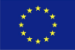    This work has been realised in the context of Odeuropa, a research project that has received funding from the European Union's Horizon 2020 research and innovation programme under grant agreement No. 101004469.

---